# Twitter Sentiment Analysis Using Machine Learning and NLP

**Note**:Im Performing the Analysis in Google Colab to avoid Libraries issues.
and i have used some new libraries for Preprocessing so kindly Install .
 to install libraies use !pip install library name in command line
 its Optional to use Google Colab else Jupyternotebook works fine just to avoid issues while installing these Libraries

### Importing the Necessary Libraries

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import emoji
import spacy as sp
nlp = sp.load('en_core_web_sm') 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from warnings import filterwarnings
filterwarnings('ignore')

### Load The Dataset

In [4]:
df=pd.read_excel("LabeledText.xlsx")
df.head()

,File Name,Caption,LABEL
0,1.txt,How I feel today #legday #jelly #aching #gym,negative
1,10.txt,@ArrivaTW absolute disgrace two carriages from...,negative
2,100.txt,This is my Valentine's from 1 of my nephews. I...,positive
3,1000.txt,betterfeelingfilms: RT via Instagram: First da...,neutral
4,1001.txt,Zoe's first love #Rattled @JohnnyHarper15,positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4869 entries, 0 to 4868
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File Name  4869 non-null   object
 1   Caption    4869 non-null   object
 2   LABEL      4869 non-null   object
dtypes: object(3)
memory usage: 114.2+ KB


* There are 4869 rows and 3 Columns
* All the # columns are of Object/categorical Datatype

In [11]:
df.describe()

,File Name,Caption,LABEL
count,4869,4869,4869
unique,4869,4663,3
top,1.txt,#February #Winter #Rainy #Stormy #Windy #Tuesd...,neutral
freq,1,10,1771


* Most Occured Caption 	February #Winter #Rainy #Stormy #Windy #Tuesd..
* Most Occured Label 	neutral

In [13]:
df.isnull().sum().sum()

0

### There are no any Null values Present

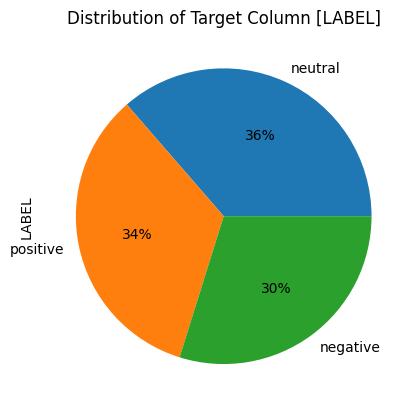

In [61]:
df['LABEL'].value_counts(normalize=True).plot(kind='pie',autopct='%2.f%%')
plt.title('Distribution of Target Column [LABEL]')
plt.show()

In [18]:
df.sample(6)

,File Name,Caption,LABEL
4612,768.txt,RT @RexTheSuperLab: Help find my friend..5 mon...,negative
1021,1918.txt,Behold the lilies of the field.....#bible #car...,positive
1446,247.txt,RT @CazZxox: #dizzy #GamerGate #PS3 #perfect,positive
2315,3299.txt,RT @500pxGallery: Marooned #4 by EdMorris #500...,neutral
1534,2566.txt,RT @tribecalledgod: Kendrick Lamar - Cut You Off,neutral
3994,4828.txt,RT @m_r_o__: ¤¨¤²¤Ä¤Ê¤¤ http://t.co/Ox4Z8oBkpJ,neutral


In [20]:
df['LABEL'].unique()

array(['negative', 'positive', 'neutral'], dtype=object)

### There are 3 Sentiments Observed in the Label Columns Namely Positive,Neutral,Negative . 
* With Neutral Comment as  Most Frequent


---



In [21]:
df.LABEL.value_counts()

neutral     1771
positive    1646
negative    1452
Name: LABEL, dtype: int64

## Cleaning data and Lemmatization

In [25]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234911 sha256=7ee4baa4450c031e1c9c635ad4e16a5d57190e78a068b7b3402536bd82b2ea7c
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji


In [26]:
import emoji

In [23]:
df.head()

,File Name,Caption,LABEL
0,1.txt,How I feel today #legday #jelly #aching #gym,negative
1,10.txt,@ArrivaTW absolute disgrace two carriages from...,negative
2,100.txt,This is my Valentine's from 1 of my nephews. I...,positive
3,1000.txt,betterfeelingfilms: RT via Instagram: First da...,neutral
4,1001.txt,Zoe's first love #Rattled @JohnnyHarper15,positive


In [27]:
def cleanTweets(text):
    text = re.sub('[^a-zA-Z]', ' ', str(text).lower().strip())
    text = re.sub('@[A-Za-z0-9_]+', '', text) 
    text = re.sub('#','',text) 
    text = re.sub('RT[\s]+','',text)
    text = re.sub('https?:\/\/\S+', '', text) 
    text = re.sub('\n',' ',text)
    text = emoji.replace_emoji(text, replace='')
    return text
df['cleanedTweet'] = df['Caption'].apply(cleanTweets) 
df.sample(5)

,File Name,Caption,LABEL,cleanedTweet
2293,3279.txt,"RT @Wimbledon: With help from @toddwoodbridge,...",negative,rt wimbledon with help from toddwoodbridge ...
4474,643.txt,RT @BosTeenAuthFest: We're thrilled to announc...,positive,rt bosteenauthfest we re thrilled to announc...
3769,4625.txt,#FanArmyFaceOff #Directioners http://t.co/YyPn...,neutral,fanarmyfaceoff directioners http t co yypn...
3451,4339.txt,RT @kj_fetishmodel: heres some grocery butt ht...,neutral,rt kj fetishmodel heres some grocery butt ht...
4308,511.txt,RT @501stLegion: RT @501NEG: 2 things a Stormt...,negative,rt stlegion rt neg things a stormt...


# Text PreProcessing

In [29]:
def text_preprocessing(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)
df['cleanedTweet'] = df['cleanedTweet'].apply(text_preprocessing)
df.sample(5)

,File Name,Caption,LABEL,cleanedTweet
3379,4274.txt,RT @eNCA: S Sudan troops 'crushed civilians wi...,negative,rt enca s sudan troop crush civilian tan...
86,1076.txt,"With the 2015 class signed, we're turning our ...",positive,class sign turn focus class ...
629,1565.txt,RT @MiaLarson: Via @thejenwilkinson: Who are w...,negative,rt mialarson thejenwilkinson willing h...
2841,3783.txt,RT @TennisAtlantic: Newport Problems: @klein_b...,negative,rt tennisatlantic newport problem klein...
3748,4606.txt,Right now on Sky looks like a battle of good @...,positive,right sky look like battle good owenjone ...


**After Some Cleaning and Preprocessing we Can Clearly Observe the Changes in the Cleaned Tweets vs Caption**

# Split the dataset

In [32]:
X = df['cleanedTweet']
y = df['LABEL']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,shuffle=True,stratify=y)

**Why We Use Multinomial naive bayes ?**

-->The multinomial model provides an ability to classify data, that cannot be represented numerically. Its main advantage is the significantly reduced complexity. It provides an ability to perform the classification, using small training sets, not requiring to be continuously re-trained.

In [33]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [34]:
model = MultinomialNB()
model.fit(X_train,y_train)
model.score(X_train,y_train)

0.9658536585365853

In [35]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.6919917864476386


In [37]:
from sklearn.metrics import classification_report

In [38]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negative       0.69      0.64      0.66       291
     neutral       0.65      0.60      0.63       354
    positive       0.73      0.84      0.78       329

    accuracy                           0.69       974
   macro avg       0.69      0.69      0.69       974
weighted avg       0.69      0.69      0.69       974



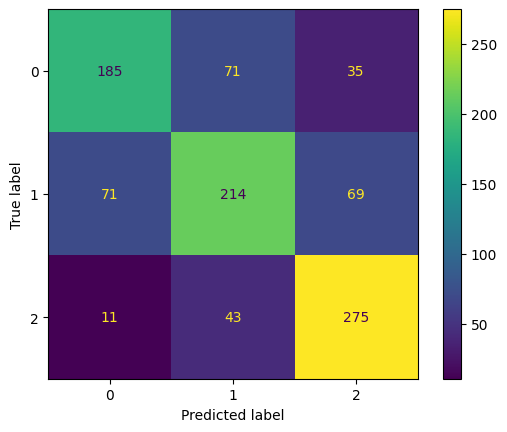

In [39]:
cf = confusion_matrix(y_test, y_pred)
plotcf = ConfusionMatrixDisplay(cf)
plotcf.plot()
plt.show()


# Lets Try TF-IDF Vectoriser

In [43]:
X = df['cleanedTweet']
y = df['LABEL']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,shuffle=True)

In [44]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [45]:
model = MultinomialNB()
model.fit(X_train,y_train)
model.score(X_train,y_train)

0.9668806161745828

In [46]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print('Accuracy-score',accuracy)

Accuracy-score 0.6971252566735113


In [47]:
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

    negative       0.78      0.59      0.67       281
     neutral       0.65      0.67      0.66       362
    positive       0.70      0.82      0.75       331

    accuracy                           0.70       974
   macro avg       0.71      0.69      0.69       974
weighted avg       0.70      0.70      0.69       974



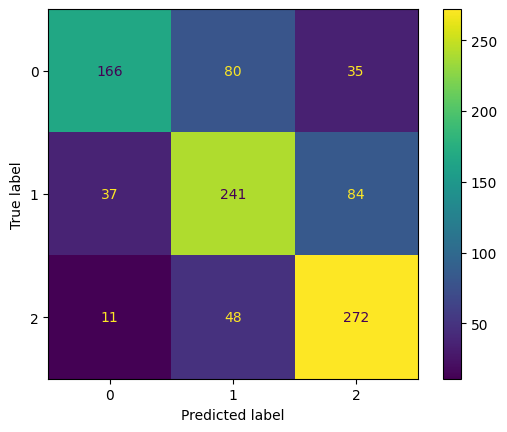

In [48]:
cf = confusion_matrix(y_test, y_pred)
plotcf = ConfusionMatrixDisplay(cf)
plotcf.plot()
plt.show()


In [49]:
# tfidf vectoriser performs a bit better compared to count-vectoriser in predicting True positived

# Conclusion 

* Positive sentiment:
- True positives: 166
- False negatives: 80
- False positives: 37
* The model correctly identified 166 positive sentiments, but it incorrectly predicted 80 positive sentiments as negative and 37 positive sentiments as neutral.

* Negative sentiment:
- True negatives: 241
- False positives: 84
- False negatives: 48
* The model correctly identified 241 negative sentiments, but it incorrectly predicted 84 negative sentiments as positive and 48 negative sentiments as neutral.

* Neutral sentiment:
- True negatives: 272
- False positives: 11
- False negatives: 48
* The model correctly identified 272 neutral sentiments, but it incorrectly predicted 11 neutral sentiments as positive and 48 neutral sentiments as negative.

* Based on this information, you can draw the following conclusions for your sentiment analysis project:

* The model performs relatively well in identifying negative sentiments, with a high number of true negatives (241). However, it has a relatively high number of false positives (84) and false negatives (48) for negative sentiments.

* The model has a decent performance in identifying positive sentiments, with a reasonable number of true positives (166). However, it has a relatively high number of false negatives (80) and false positives (37) for positive sentiments.

* The model performs relatively well in identifying neutral sentiments, with a high number of true negatives (272). However, it has a small number of false positives (11) and a significant number of false negatives (48) for neutral sentiments.





# THANK YOU 